# Exercise: Aequitas
In this exercise, you will use Aequitas to investigate the potential bias in a model/data set.
* We'll use the [Car Evaluation Data Set from the UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation), a notebook that trains a logistic regression model to determine the car's acceptability is provided.
* Using Aequitas, determine if the model contains bias. For simplicity, from Aequitas' Fairness class obtain the results of the `get_overall_fairness` method which returns a dictionary with Yes/No result for "Unsupervised Fairness", "Supervised Fairness" and "Overall Fairness".
* Lastly, use the `aequitas.plotting.Plot` module and compute the summary on `fpr`, `fnr`, and `for` with a 1.25 `fairness_threshold`.
* You can draw inspiration from examples present here: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb

## Data Description - Car Evaluation Database

### Sources
(a) Creator: Marko Bohanec

(b) Donors: Marko Bohanec   (marko.bohanec@ijs.si)
            Blaz Zupan      (blaz.zupan@ijs.si)

(c) Date: June, 1997

### Relevant Information

Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX (M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates cars according to the following concept structure:
```
CAR                      car acceptability
. PRICE                  overall price
. . buying               buying price
. . maint                price of the maintenance
. TECH                   technical characteristics
. . COMFORT              comfort
. . . doors              number of doors
. . . persons            capacity in terms of persons to carry
. . . lug_boot           the size of luggage boot
. . safety               estimated safety of the car
```
Input attributes are printed in lowercase. Besides the __target concept (CAR)__, the model includes three intermediate concepts: __PRICE, TECH, COMFORT__. Every concept is in the original model related to its lower level descendants by a set of examples (for these examples sets see http://www-ai.ijs.si/BlazZupan/car.html).

The Car Evaluation Database contains examples with the __structural information removed__, i.e., __directly relates CAR to the six input attributes: buying, maint, doors, persons, lug_boot, safety__.

Because of known underlying concept structure, this database may be particularly useful for testing constructive induction and structure discovery methods.

### Dataset description
Number of Instances: 1728 (instances completely cover the attribute space)

Number of Attributes: 6

Attribute Values:
```
   buying       v-high, high, med, low

   maint        v-high, high, med, low

   doors        2, 3, 4, 5-more

   persons      2, 4, more

   lug_boot     small, med, big

   safety       low, med, high
```

Missing Attribute Values: none

Class Distribution (number of instances per class)
```
   class      N          N[%]
   -----------------------------
   unacc     1210     (70.023 %) 
   acc        384     (22.222 %) 
   good        69     ( 3.993 %) 
   v-good      65     ( 3.762 %)
```

## Model training

In [1]:
# Imports
from aequitas.plotting import Plot
ap = Plot()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from aequitas.group import Group
from aequitas.bias import Bias 
from aequitas.fairness import Fairness

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# I manually added the headers to the data set.
df = pd.read_csv("./car.csv")

# We'll modify the data to make it a binary problem of acceptable or unacceptable car.
df = df.where(df != 'good', 'acc')
df = df.where(df != 'vgood', 'acc')

y = df.pop('car')
X = df

df.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# Use this later to construct the DataFrame Aequitas requires.
df_aq = X_test.copy()

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_train = ohe.fit_transform(X_train.values)
X_test = ohe.transform(X_test.values)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train).ravel()
y_test = lb.transform(y_test).ravel()

X_train shape:  (1296, 6)
X_test shape:  (432, 6)


In [4]:
print('Class labels:')
for i, v in enumerate(lb.classes_):
    print(f'{v} encoded into {i}')

Class labels:
acc encoded into 0
unacc encoded into 1


In [5]:
print("Categories of OHE:")
for feature in ohe.categories_:
    print(feature.tolist())
print(f'Shape of X_train after OHE: {X_train.shape}')

Categories of OHE:
['high', 'low', 'med', 'vhigh']
['high', 'low', 'med', 'vhigh']
['2', '3', '4', '5more']
['2', '4', 'more']
['big', 'med', 'small']
['high', 'low', 'med']
Shape of X_train after OHE: (1296, 21)


In [6]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

scores = lr.predict_proba(X_test)
pred = lr.predict(X_test)

f1 = f1_score(y_test, pred)
print(f"F1 score: {f1:.4f}")

F1 score: 0.9577


## Pre-Aequitas: Exploring "Car Evaluation Database"

In [7]:
df_aq['label_value_name'] = lb.inverse_transform(y_test)
df_aq['label_value'] = y_test
df_aq['score_name'] = lb.inverse_transform(pred)
df_aq['score'] = pred
df_aq.head()

,buying,maint,doors,persons,lug_boot,safety,label_value_name,label_value,score_name,score
1278,med,low,5more,4,small,low,unacc,1,unacc,1
477,high,vhigh,3,more,small,low,unacc,1,unacc,1
1688,low,low,4,4,med,high,acc,0,acc,0
1444,low,high,3,4,med,med,acc,0,acc,0
206,vhigh,high,5more,4,big,high,unacc,1,acc,0


### Bivariate analysis w.r.t. true class label (without mean and standard deviation)

In [8]:
aq_palette = sns.diverging_palette(225, 35, n=2)

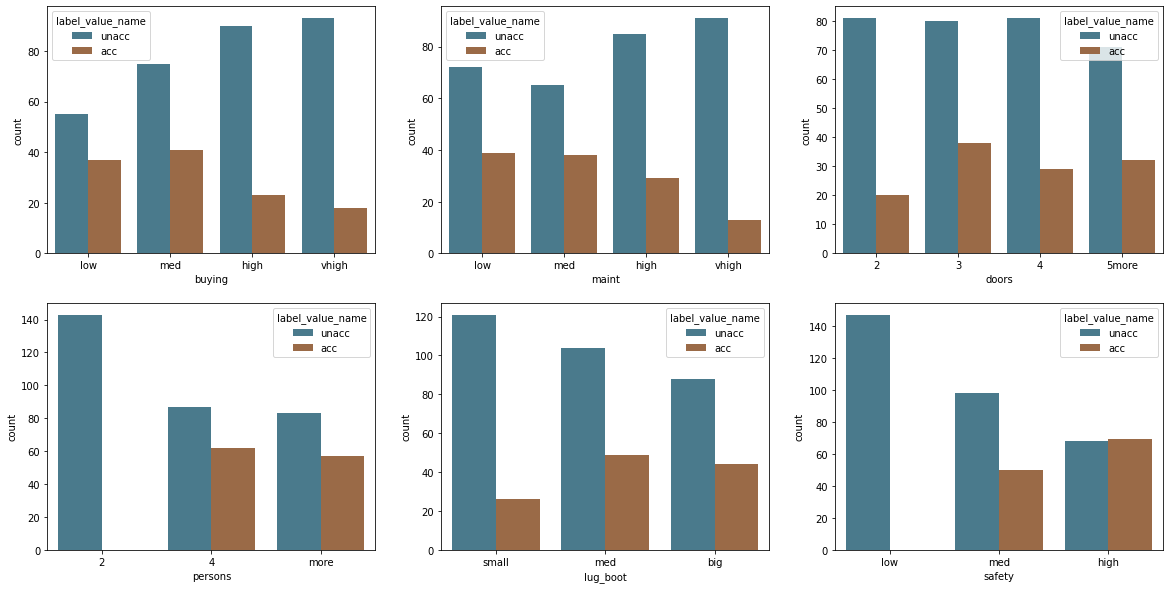

In [9]:
cat_columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
orders = {
    'buying': ['low', 'med', 'high', 'vhigh'],
    'maint': ['low', 'med', 'high', 'vhigh'],
    'doors': ['2', '3', '4', '5more'],
    'persons': ['2', '4', 'more'],
    'lug_boot': ['small', 'med', 'big'],
    'safety': ['low', 'med', 'high'],
}

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))

for i, col in enumerate(cat_columns):
    ix = i % 3
    iy = i // 3
    # axes[iy, ix].set_title(col)
    sns.countplot(x = col, hue = "label_value_name", order = orders[col], data = df_aq, palette = aq_palette, ax = axes[iy, ix])

Summary:
- 2 persons car are always unaccepted
- Higher the buying price less acceptable car is
- Higher the maintenance price less acceptable car is
- Low safety cars are always unacceptable

### Bivariate analysis w.r.t. predicted class label (without mean and standard deviation)

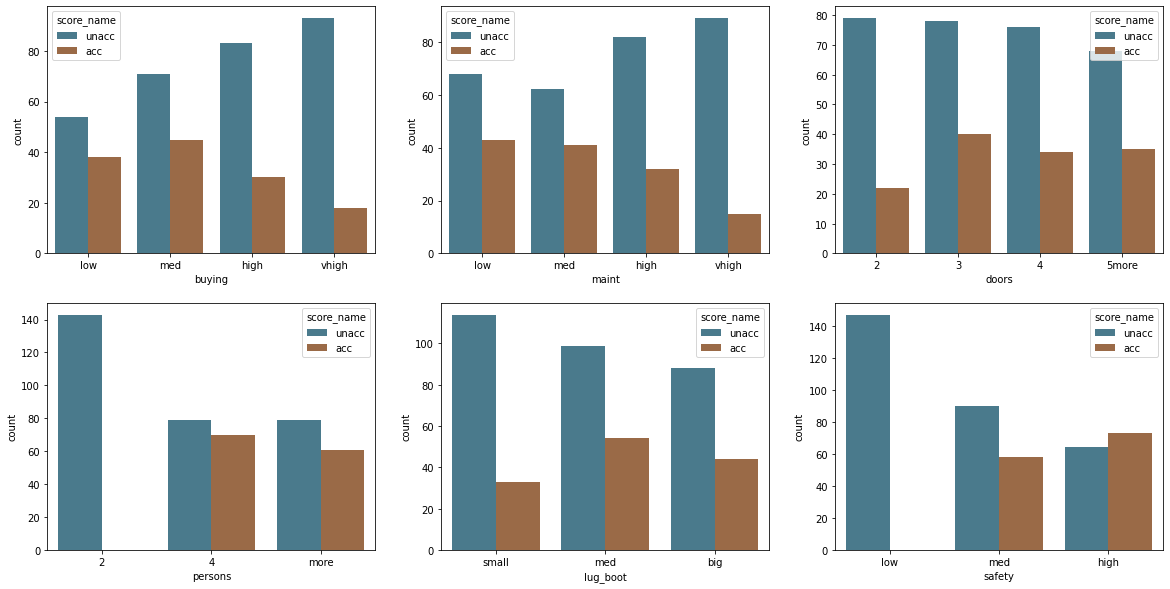

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))

for i, col in enumerate(cat_columns):
    ix = i % 3
    iy = i // 3
    # axes[iy, ix].set_title(col)
    sns.countplot(x = col, hue = "score_name", order = orders[col], data = df_aq, palette = aq_palette, ax = axes[iy, ix])

Picture is similar to the true labels

### Confusion matrix of model predictions

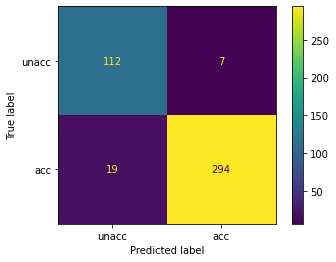

F1 score: 0.9577


In [11]:
cm = confusion_matrix(y_test, pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["unacc", "acc"]).plot()
plt.show()

f1 = f1_score(y_test, pred)
print(f"F1 score: {f1:.4f}")

The model is doing overall good with F1 score 0.9577
- 19 cars were misclassified as acceptable out of 313 total acceptable cars
- 7 cars were misclassified as non-acceptable out of 119 total unacceptable cars 

### Putting Aequitas to the task

In [31]:
df_aq = df_aq[[c for c in df_aq.columns if c not in ['label_value_name', 'score_name']]]
df_aq.head()

,buying,maint,doors,persons,lug_boot,safety,label_value,score
1278,med,low,5more,4,small,low,1,1.0
477,high,vhigh,3,more,small,low,1,1.0
1688,low,low,4,4,med,high,0,0.0
1444,low,high,3,4,med,med,0,0.0
206,vhigh,high,5more,4,big,high,1,0.0


### _Aequitas `Group()` Class_

Aequita's `Group()` class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group prevalence among the sample distribution.

The __`get_crosstabs()`__ method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevalences.

In [52]:
group = Group()
xtab, idxs = group.get_crosstabs(df_aq)
absolute_metrics = group.list_absolute_metrics(xtab)

# xtab[[col for col in xtab.columns if col not in absolute_metrics + ['model_id', 'score_threshold', 'k', 'pp', 'pn', 'group_label_pos', 'group_label_neg']]]
xtab[['attribute_name', 'attribute_value', 'tp', 'fp', 'tn', 'fn', 'group_size', 'total_entities']]

,attribute_name,attribute_value,tp,fp,tn,fn,group_size,total_entities
0,buying,high,81,2,21,9,113,432
1,buying,low,53,1,36,2,92,432
2,buying,med,71,0,41,4,116,432
3,buying,vhigh,89,4,14,4,111,432
4,maint,high,79,3,26,6,114,432
5,maint,low,66,2,37,6,111,432
6,maint,med,60,2,36,5,103,432
7,maint,vhigh,89,0,13,2,104,432
8,doors,2,76,3,17,5,101,432
9,doors,3,75,3,35,5,118,432


In [53]:
# xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)
xtab[['attribute_name', 'attribute_value'] + ['tpr', 'tnr', 'precision', 'npv']].round(2)

,attribute_name,attribute_value,tpr,tnr,precision,npv
0,buying,high,0.90,0.91,0.98,0.70
1,buying,low,0.96,0.97,0.98,0.95
2,buying,med,0.95,1.00,1.00,0.91
3,buying,vhigh,0.96,0.78,0.96,0.78
4,maint,high,0.93,0.90,0.96,0.81
5,maint,low,0.92,0.95,0.97,0.86
6,maint,med,0.92,0.95,0.97,0.88
7,maint,vhigh,0.98,1.00,1.00,0.87
8,doors,2,0.94,0.85,0.96,0.77
9,doors,3,0.94,0.92,0.96,0.88


__NOTE__: didn't understand what `k`, `pprev` and `prev` account for.
* `k` - total pred. positive - total number of entities predicted positive from whole dataset
* `prev` - prevalence -  is a fraction of entities within a group which are true positive (`(TP + FN)/group_size`)
* `pprev` - predicted prevalence - is a fraction of entities within a group which were predicted as positive (`TP + FP/group_size`)

_PERSONAL NOTE_: 
* Basically we don't need these measures - `k`, `prev`, `pprev`, `fdr`, `for`, `fpr`, `fnr`
* `fdr`, `for`, `fpr`, `fnr` can be calculated through `ppv`, `npv`, `tnr`, `tpr` correspondingly
* __Disparity__ is a ratio of a groups metric compared to a reference group. Notice the reference group will always have disparity of 1.

#### _Aequitas `Bias()` class_

We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class __`get_crosstabs()`__ method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group.

In [60]:
bias = Bias()
bias_df = bias.get_disparity_major_group(xtab, original_df=df_aq, alpha=0.05, mask_significance=True)
bias_df.round(2)

get_disparity_major_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,301,buying,high,0.90,0.91,0.30,0.02,0.09,0.10,0.70,0.98,83,30,0.28,0.73,2,9,21,81,90,23,113,432,0.80,1.17,1.20,0.98,10.00,3.37,10.00,1.88,0.95,0.91,0.77,med,med,med,med,med,med,med,med,med,med
1,0,binary 0/1,301,buying,low,0.96,0.97,0.05,0.02,0.03,0.04,0.95,0.98,54,38,0.18,0.59,1,2,36,53,55,37,92,432,0.60,0.76,0.96,0.98,10.00,0.59,10.00,0.68,1.02,0.97,1.04,med,med,med,med,med,med,med,med,med,med
2,0,binary 0/1,301,buying,med,0.95,1.00,0.09,0.00,0.00,0.05,0.91,1.00,71,45,0.24,0.61,0,4,41,71,75,41,116,432,0.65,1.00,1.00,1.00,NaN,1.00,NaN,1.00,1.00,1.00,1.00,med,med,med,med,med,med,med,med,med,med
3,0,binary 0/1,301,buying,vhigh,0.96,0.78,0.22,0.04,0.22,0.04,0.78,0.96,93,18,0.31,0.84,4,4,14,89,93,18,111,432,0.84,1.31,1.37,0.96,10.00,2.50,10.00,0.81,1.01,0.78,0.85,med,med,med,med,med,med,med,med,med,med
4,0,binary 0/1,301,maint,high,0.93,0.90,0.19,0.04,0.10,0.07,0.81,0.96,82,32,0.27,0.72,3,6,26,79,85,29,114,432,0.75,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,high,high,high,high,high,high,high,high,high,high
5,0,binary 0/1,301,maint,low,0.92,0.95,0.14,0.03,0.05,0.08,0.86,0.97,68,43,0.23,0.61,2,6,37,66,72,39,111,432,0.65,0.83,0.85,1.01,0.80,0.74,0.50,1.18,0.99,1.06,1.06,high,high,high,high,high,high,high,high,high,high
6,0,binary 0/1,301,maint,med,0.92,0.95,0.12,0.03,0.05,0.08,0.88,0.97,62,41,0.21,0.60,2,5,36,60,65,38,103,432,0.63,0.76,0.84,1.00,0.88,0.65,0.51,1.09,0.99,1.06,1.08,high,high,high,high,high,high,high,high,high,high
7,0,binary 0/1,301,maint,vhigh,0.98,1.00,0.13,0.00,0.00,0.02,0.87,1.00,89,15,0.30,0.86,0,2,13,89,91,13,104,432,0.88,1.09,1.19,1.04,0.00,0.71,0.00,0.31,1.05,1.12,1.07,high,high,high,high,high,high,high,high,high,high
8,0,binary 0/1,301,doors,2,0.94,0.85,0.23,0.04,0.15,0.06,0.77,0.96,79,22,0.26,0.78,3,5,17,76,81,20,101,432,0.80,1.01,1.18,1.00,0.99,1.82,1.90,0.99,1.00,0.92,0.88,3,3,3,3,3,3,3,3,3,3
9,0,binary 0/1,301,doors,3,0.94,0.92,0.12,0.04,0.08,0.06,0.88,0.96,78,40,0.26,0.66,3,5,35,75,80,38,118,432,0.68,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,3,3,3,3,3,3,3,3,3,3


In [59]:
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)
fairness_df.round(2)

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,301,buying,high,0.90,0.91,0.30,0.02,0.09,0.10,0.70,0.98,83,30,0.28,0.73,2,9,21,81,90,23,113,432,0.80,1.17,1.20,0.98,10.00,3.37,10.00,1.88,0.95,0.91,0.77,med,med,med,med,med,med,med,med,med,med,True,True,False,False,False,False,True,True,False,True,False,False,False,True,False
1,0,binary 0/1,301,buying,low,0.96,0.97,0.05,0.02,0.03,0.04,0.95,0.98,54,38,0.18,0.59,1,2,36,53,55,37,92,432,0.60,0.76,0.96,0.98,10.00,0.59,10.00,0.68,1.02,0.97,1.04,med,med,med,med,med,med,med,med,med,med,False,True,False,False,False,False,True,True,True,True,False,False,False,False,False
2,0,binary 0/1,301,buying,med,0.95,1.00,0.09,0.00,0.00,0.05,0.91,1.00,71,45,0.24,0.61,0,4,41,71,75,41,116,432,0.65,1.00,1.00,1.00,NaN,1.00,NaN,1.00,1.00,1.00,1.00,med,med,med,med,med,med,med,med,med,med,True,True,NaN,NaN,True,True,True,True,True,True,NaN,True,False,True,False
3,0,binary 0/1,301,buying,vhigh,0.96,0.78,0.22,0.04,0.22,0.04,0.78,0.96,93,18,0.31,0.84,4,4,14,89,93,18,111,432,0.84,1.31,1.37,0.96,10.00,2.50,10.00,0.81,1.01,0.78,0.85,med,med,med,med,med,med,med,med,med,med,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False
4,0,binary 0/1,301,maint,high,0.93,0.90,0.19,0.04,0.10,0.07,0.81,0.96,82,32,0.27,0.72,3,6,26,79,85,29,114,432,0.75,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,high,high,high,high,high,high,high,high,high,high,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,0,binary 0/1,301,maint,low,0.92,0.95,0.14,0.03,0.05,0.08,0.86,0.97,68,43,0.23,0.61,2,6,37,66,72,39,111,432,0.65,0.83,0.85,1.01,0.80,0.74,0.50,1.18,0.99,1.06,1.06,high,high,high,high,high,high,high,high,high,high,True,True,True,False,False,True,True,True,True,True,False,False,False,True,False
6,0,binary 0/1,301,maint,med,0.92,0.95,0.12,0.03,0.05,0.08,0.88,0.97,62,41,0.21,0.60,2,5,36,60,65,38,103,432,0.63,0.76,0.84,1.00,0.88,0.65,0.51,1.09,0.99,1.06,1.08,high,high,high,high,high,high,high,high,high,high,False,True,True,False,False,True,True,True,True,True,False,False,False,False,False
7,0,binary 0/1,301,maint,vhigh,0.98,1.00,0.13,0.00,0.00,0.02,0.87,1.00,89,15,0.30,0.86,0,2,13,89,91,13,104,432,0.88,1.09,1.19,1.04,0.00,0.71,0.00,0.31,1.05,1.12,1.07,high,high,high,high,high,high,high,high,high,high,True,True,False,False,False,False,True,True,True,True,False,False,False,True,False
8,0,binary 0/1,301,doors,2,0.94,0.85,0.23,0.04,0.15,0.06,0.77,0.96,79,22,0.26,0.78,3,5,17,76,81,20,101,432,0.80,1.01,1.18,1.00,0.99,1.82,1.90,0.99,1.00,0.92,0.88,3,3,3,3,3,3,3,3,3,3,True,True,True,False,False,True,True,True,True,True,False,False,False,True,False
9,0,binary 0/1,301,doors,3,0.94,0.92,0.12,0.04,0.08,0.06,0.88,0.96,78,40,0.26,0.66,3,5,35,75,80,38,118,432,0.68,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,3,3,3,3,3,3,3,3,3,3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [55]:
overall_fairness = fairness.get_overall_fairness(fairness_df)
print(overall_fairness)

{'Unsupervised Fairness': False, 'Supervised Fairness': False, 'Overall Fairness': False}


In [56]:
metrics = ['fpr', "for", "fnr"]
disparity_metrics = [f"{metric}_disparity" for metric in metrics]

In [58]:
# Just as we discussed above, some statistics are zero or NAN
bias_df[["attribute_name", "attribute_value"] + metrics + disparity_metrics].round(2)

,attribute_name,attribute_value,fpr,for,fnr,fpr_disparity,for_disparity,fnr_disparity
0,buying,high,0.09,0.30,0.10,10.00,3.37,1.88
1,buying,low,0.03,0.05,0.04,10.00,0.59,0.68
2,buying,med,0.00,0.09,0.05,NaN,1.00,1.00
3,buying,vhigh,0.22,0.22,0.04,10.00,2.50,0.81
4,maint,high,0.10,0.19,0.07,1.00,1.00,1.00
5,maint,low,0.05,0.14,0.08,0.50,0.74,1.18
6,maint,med,0.05,0.12,0.08,0.51,0.65,1.09
7,maint,vhigh,0.00,0.13,0.02,0.00,0.71,0.31
8,doors,2,0.15,0.23,0.06,1.90,1.82,0.99
9,doors,3,0.08,0.12,0.06,1.00,1.00,1.00


In [61]:
# To avoid issues when plotting, add an epilon (0.000001) to cases where statistics are zero or NAN
eps = 0.000001
bias_df[disparity_metrics] = bias_df[disparity_metrics].fillna(0.0) + eps

In [63]:
bias_df[["attribute_name", "attribute_value"] + metrics + disparity_metrics].round(2)

,attribute_name,attribute_value,fpr,for,fnr,fpr_disparity,for_disparity,fnr_disparity
0,buying,high,0.09,0.30,0.10,10.00,3.38,1.88
1,buying,low,0.03,0.05,0.04,10.00,0.59,0.68
2,buying,med,0.00,0.09,0.05,0.00,1.00,1.00
3,buying,vhigh,0.22,0.22,0.04,10.00,2.50,0.81
4,maint,high,0.10,0.19,0.07,1.00,1.00,1.00
5,maint,low,0.05,0.14,0.08,0.50,0.74,1.18
6,maint,med,0.05,0.12,0.08,0.51,0.65,1.09
7,maint,vhigh,0.00,0.13,0.02,0.00,0.71,0.31
8,doors,2,0.15,0.23,0.06,1.90,1.82,0.99
9,doors,3,0.08,0.12,0.06,1.00,1.00,1.00


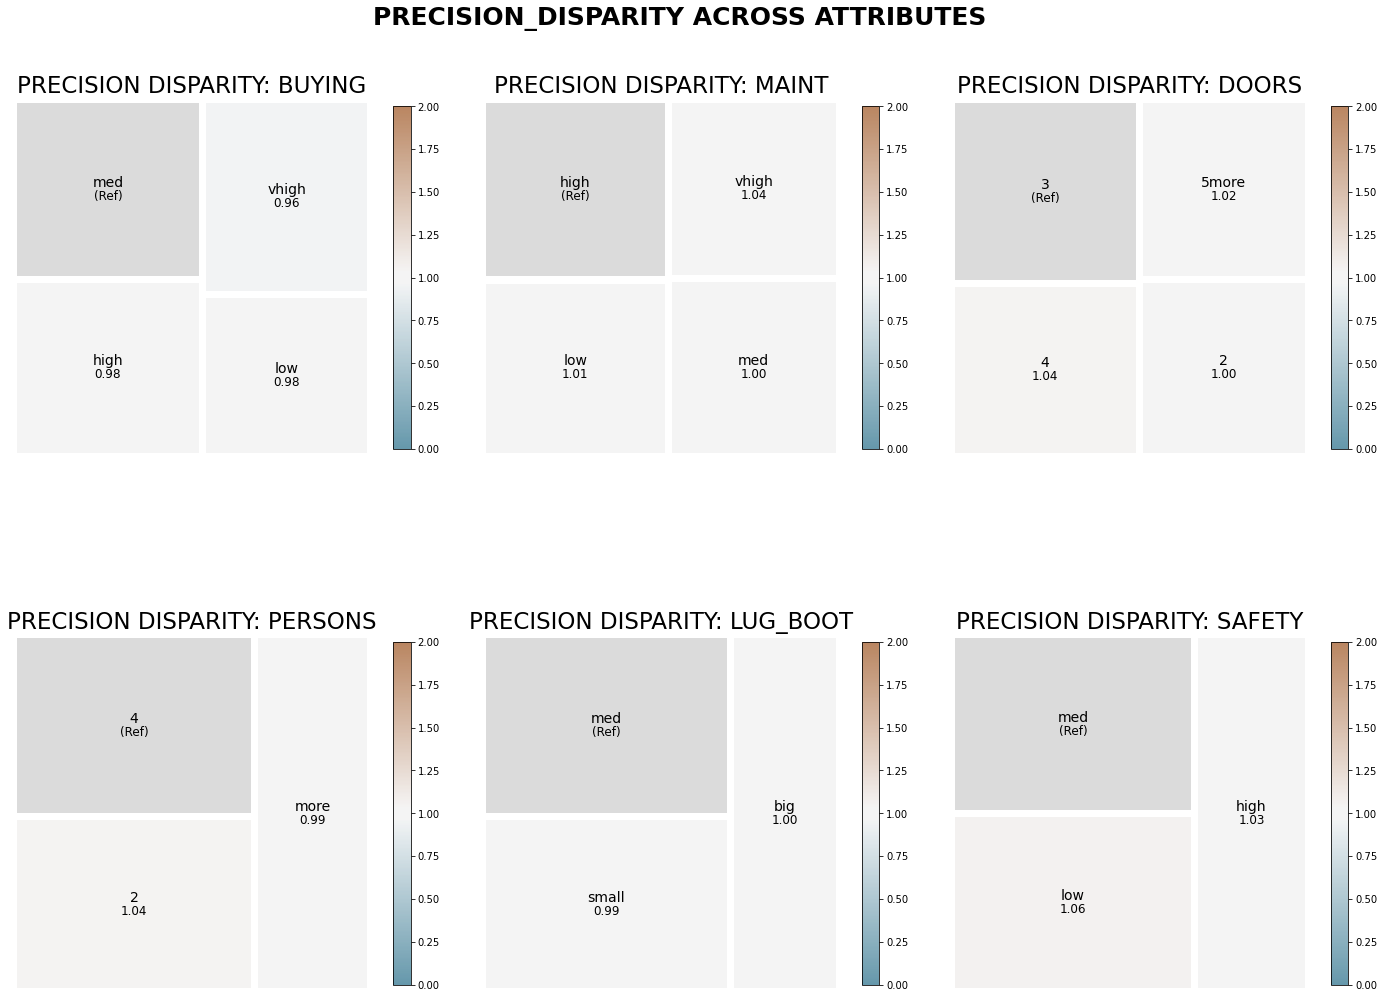

In [64]:
disparity_tolerance = 1.25

# Deprecated function summary()
# ap.summary(bias_df, metrics, fairness_threshold=disparity_tolerance)

# Aequitas Fairness() class provides a few functions that provide a high level summary of fairness and disparity, such as 
# plot_fairness_group()
# plot_fairness_group_all()
# plot_fairness_disparity()
# plot_fairness_disparity_all()
# plot_disparity()
# See some example here: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb 
p = ap.plot_disparity_all(bias_df, metrics=['precision_disparity'], significance_alpha=0.05)
